In [1]:
!pip install catboost

In [10]:
!pip install -q tensorflow==2.3

In [11]:
#аугментации изображений
!pip install albumentations -q

In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [13]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.18.1
Tensorflow   : 2.3.0


In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [7]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [14]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [16]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [17]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [18]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

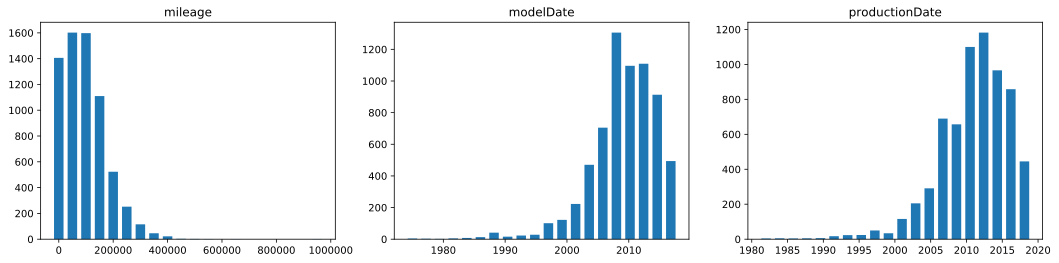

In [19]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:

    CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [20]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','Владение','enginePower','engineDisplacement']

In [21]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [22]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [23]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
7399,внедорожник 5 дв.,BMW,коричневый,"Авто в одних руках,все обслуживание по реглам...",2.0 LTR,245 N12,бензин,107000,2014,X3,...,1091374938,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,4 года и 9 месяцев,Оригинал,полный,Левый,1,1590000.0
4273,внедорожник 5 дв.,BMW,чёрный,"Год выпуска 2016, приобрел новую без пробега в...",2.0 LTR,245 N12,гибрид,45000,2013,X5,...,1099098578,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый,1,3100000.0
3362,седан,MERCEDES,чёрный,В идеальном состоянии. Обслуживание в Панавто ...,5.5 LTR,585 N12,бензин,55000,2013,S_KLASSE_AMG,...,1094635516,SEDAN AUTOMATIC 5.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,3750000.0


In [24]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [25]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id',], axis = 1, inplace=True)
    
     # ################### Feature Engineering ####################################################
    #Владение
    def num_of_months(row):
        if pd.notnull(row):
            list_ownership = row.split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
    df_output['Владение'] = df_output['Владение'].apply(num_of_months)
    
    # enginePower, оставим только цифру в enginePower
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x.split()[0]))
    
     # engineDisplacement, оставим только цифру в engineDisplacement
    df_output['engineDisplacement'][df_output['engineDisplacement'] == 'undefined LTR'] = 'NaN'    
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: float(x.split()[0]))
    
    df_output['Владельцы']=df_output['Владельцы'].dropna()
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        if column == 'modelDate':
            df_output['modelDate'] = np.log(2020 - data['modelDate'])
        else:
            df_output[column]=df_output[column].apply(lambda x: np.log(x))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration','name'], axis = 1, inplace=True)
    
    return df_output

In [26]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

C:\Users\Admin\anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.467888,0.439126,0.891384,0.638495,0.686257,0.840323,1,630000.0,0,0,...,1,0,0,0,1,0,0,1,1,0
6421,0.467888,0.310328,0.866257,0.616137,0.791046,0.619468,1,680000.0,0,1,...,0,1,0,0,1,1,0,0,1,0
7645,0.420931,0.339223,0.829621,0.659062,0.712474,0.619468,1,599000.0,0,0,...,0,1,0,0,1,0,1,0,1,0
7222,0.467888,0.529985,0.757345,0.413544,0.895627,0.619468,1,2150000.0,0,1,...,0,1,0,0,1,0,0,1,1,0
4604,0.648598,0.553132,0.852324,0.616137,0.791046,0.619468,1,1290000.0,0,0,...,0,1,0,0,1,0,0,1,1,0
5140,0.275896,0.310328,0.673618,0.178104,0.973926,0.619468,1,1898000.0,0,0,...,1,0,0,0,1,0,1,0,1,0
728,0.420931,0.339223,0.866900,0.659062,0.764868,0.354121,0,0.0,0,0,...,0,0,1,0,1,0,1,0,1,0
7029,0.567340,0.477709,0.830379,0.742679,0.633785,0.449422,1,675000.0,0,0,...,1,0,0,0,1,1,0,0,1,0
1997,0.648598,0.629523,0.893054,0.659062,0.712474,0.619468,1,970000.0,0,1,...,0,0,1,0,1,0,0,1,1,0
3433,0.467888,0.463097,0.867353,0.564575,0.791046,0.619468,1,890000.0,0,0,...,0,0,1,0,1,0,0,1,1,0


In [27]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 189 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(1), uint8(181)
memory usage: 2.0 MB


In [28]:
# фукция для построения распределния и получения данных по iqr
def iqr(q):
    median = q.median()
    IQR = q.quantile(0.75) - q.quantile(0.25)
    perc25 = q.quantile(0.25)
    perc75 = q.quantile(0.75)
    print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),"IQR: {}, \
          ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
    sns.distplot(q.loc[q.between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)])

25-й перцентиль: 0.7954431723722861, 75-й перцентиль: 0.8704891439584888, IQR: 0.07504597158620263,            Границы выбросов: [0.6828742149929822, 0.9830581013377927].


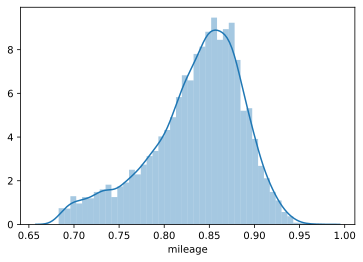

In [29]:
iqr(df_preproc['mileage'])

25-й перцентиль: 460000.0, 75-й перцентиль: 1900000.0, IQR: 1440000.0,            Границы выбросов: [-1700000.0, 4060000.0].


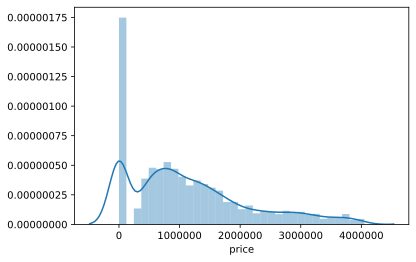

In [30]:
iqr(df_preproc['price'])

25-й перцентиль: 0.4603911105808009, 75-й перцентиль: 0.6590616115309205, IQR: 0.19867050095011957,            Границы выбросов: [0.16238535915562152, 0.9570673629560998].


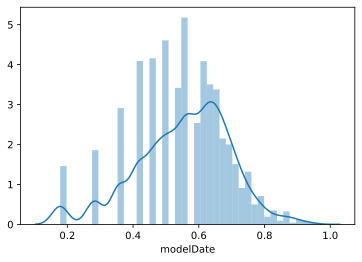

In [31]:
iqr(df_preproc['modelDate'])

25-й перцентиль: 0.712474126134282, 75-й перцентиль: 0.8956267008977079, IQR: 0.18315257476342595,            Границы выбросов: [0.43774526398914304, 1.1703555630428468].


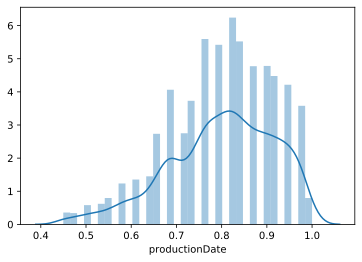

In [32]:
iqr(df_preproc['productionDate'])

count    8353.000000
mean        0.614141
std         0.087592
min         0.000000
25%         0.619468
50%         0.619468
75%         0.619468
max         1.000000
Name: Владение, dtype: float64

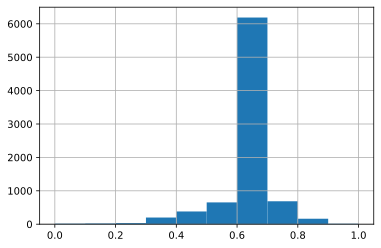

In [33]:
df_preproc['Владение'].hist()
df_preproc['Владение'].describe()

25-й перцентиль: 0.4017956525059585, 75-й перцентиль: 0.6295226921355055, IQR: 0.227727039629547,            Границы выбросов: [0.060205093061638015, 0.971113251579826].


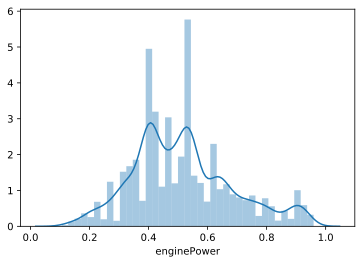

In [34]:
iqr(df_preproc['enginePower'])

25-й перцентиль: 0.4678884253526061, 75-й перцентиль: 0.6485975441080779, IQR: 0.1807091187554718,            Границы выбросов: [0.1968247472193984, 0.9196612222412857].


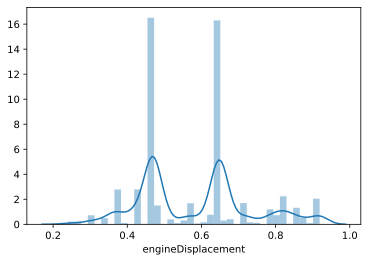

In [35]:
iqr(df_preproc['engineDisplacement'])

## Split data

In [36]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [37]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 188 entries, engineDisplacement to Руль_1
dtypes: float64(7), uint8(181)
memory usage: 399.8 KB


# Model 2: CatBoostRegressor

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [39]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         #plot=True
         )

Learning rate set to 0.023474
0:	learn: 0.9875802	test: 1.0113809	best: 1.0113809 (0)	total: 47.5ms	remaining: 3m 57s
100:	learn: 0.2985702	test: 0.2980475	best: 0.2980475 (100)	total: 303ms	remaining: 14.7s
200:	learn: 0.2289745	test: 0.2254929	best: 0.2254929 (200)	total: 508ms	remaining: 12.1s
300:	learn: 0.1988657	test: 0.1964683	best: 0.1964683 (300)	total: 722ms	remaining: 11.3s
400:	learn: 0.1810009	test: 0.1808815	best: 0.1808815 (400)	total: 936ms	remaining: 10.7s
500:	learn: 0.1744828	test: 0.1750283	best: 0.1750283 (500)	total: 1.17s	remaining: 10.5s
600:	learn: 0.1664112	test: 0.1683864	best: 0.1683864 (600)	total: 1.4s	remaining: 10.3s
700:	learn: 0.1591217	test: 0.1619063	best: 0.1619063 (700)	total: 1.64s	remaining: 10.1s
800:	learn: 0.1525082	test: 0.1555234	best: 0.1555234 (800)	total: 1.87s	remaining: 9.8s
900:	learn: 0.1478894	test: 0.1513951	best: 0.1513951 (900)	total: 2.08s	remaining: 9.47s
1000:	learn: 0.1437167	test: 0.1481393	best: 0.1481393 (1000)	total: 2.29s

In [40]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.57%


### Submission

In [44]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
sample_submission.to_csv('catboost_submission-v1.csv', index=False)

In [45]:
sample_submission.head()

,sell_id,price
0,1099427284,566000
1,1096405886,2531000
2,1100195294,687000
3,1099827282,474000
4,1100076198,2690000
